In [55]:
import os
import cv2
import numpy as np
from tqdm import tqdm

from torch.utils.data import Dataset
from skimage.filters import threshold_niblack, threshold_sauvola

In [56]:
DATASET = "/kaggle/input/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/DRIVE"

image_dir = f"{DATASET}/training/images"
mask_dir = f"{DATASET}/training/1st_manual"
fov_dir = f"{DATASET}/training/mask"

In [57]:
class DriveThresholdDataset(Dataset):
    def __init__(self, image_dir, mask_dir, fov_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.fov_dir = fov_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        base_name = img_name.split('_')[0]

        mask_name = base_name + "_manual1.gif"
        mask_path = os.path.join(self.mask_dir, mask_name)

        fov_name = base_name + "_training_mask.gif"
        fov_path = os.path.join(self.fov_dir, fov_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        green = image[:, :, 1]

        gt = cv2.imread(mask_path, 0)
        gt = (gt > 0).astype(np.uint8)

        fov = cv2.imread(fov_path, 0)
        fov = (fov > 0).astype(np.uint8)

        return green, gt, fov, img_name

In [58]:
def preprocess_image(green):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)
    return enhanced

In [59]:
def apply_niblack(image):
    thresh = threshold_niblack(image, window_size=25, k=-0.2)
    binary = image < thresh
    return binary.astype(np.uint8)


def apply_sauvola(image):
    thresh = threshold_sauvola(image, window_size=25, k=0.2)
    binary = image < thresh
    return binary.astype(np.uint8)

In [60]:
def compute_sensitivity(pred, gt, fov_mask):

    pred = pred[fov_mask == 1]
    gt = gt[fov_mask == 1]

    TP = np.sum((pred == 1) & (gt == 1))
    FN = np.sum((pred == 0) & (gt == 1))

    return TP / (TP + FN + 1e-8)

In [61]:
dataset = DriveThresholdDataset(image_dir, mask_dir, fov_dir)

sens_nib = []
sens_sau = []

for green, gt, fov, name in tqdm(dataset):

    pre = preprocess_image(green)

    # Apply FOV before threshold
    pre = pre * fov

    pred_nib = apply_niblack(pre)
    pred_sau = apply_sauvola(pre)

    pred_nib = pred_nib * fov
    pred_sau = pred_sau * fov

    s_nib = compute_sensitivity(pred_nib, gt, fov)
    s_sau = compute_sensitivity(pred_sau, gt, fov)

    sens_nib.append(s_nib)
    sens_sau.append(s_sau)

100%|██████████| 20/20 [00:01<00:00, 15.87it/s]


In [62]:
print("===== SENSITIVITY RESULTS =====")
print("Niblack Sensitivity:", np.mean(sens_nib))
print("Sauvola Sensitivity:", np.mean(sens_sau))

===== SENSITIVITY RESULTS =====
Niblack Sensitivity: 0.9056846245509924
Sauvola Sensitivity: 0.5386992708424931


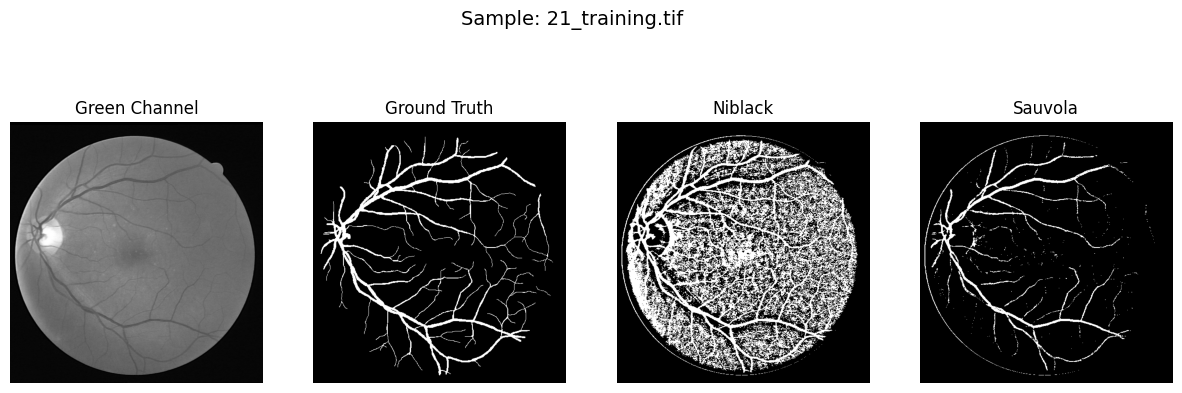

In [64]:

def show_representation(dataset, index=0):

    green, gt, fov, name = dataset[index]

    pre = preprocess_image(green)
    pre = pre * fov

    pred_nib = apply_niblack(pre)
    pred_sau = apply_sauvola(pre)

    pred_nib = pred_nib * fov
    pred_sau = pred_sau * fov

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.title("Green Channel")
    plt.imshow(green, cmap='gray')
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("Ground Truth")
    plt.imshow(gt, cmap='gray')
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Niblack")
    plt.imshow(pred_nib, cmap='gray')
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Sauvola")
    plt.imshow(pred_sau, cmap='gray')
    plt.axis("off")

    plt.suptitle(f"Sample: {name}", fontsize=14)
    plt.show()


show_representation(dataset, index=0)